# Bug - 1D wave equation blowing up

This ipython notebook reproduces the bug discussed in `github` issue [Quazartech/DG_Maxwell Issue #6](https://github.com/QuazarTech/DG_Maxwell/issues/6)

While evolving the wave equation using forward Euler method, The amplitude of the wave function (which should be a conserved quantity) inceasases with time and eventually blows up exponentially.


>### Note

- Each function will be shown along with its corresponding test function in a cell after discussing the theory
- Variables will be declared after each function which are referenced later in the code.
- Use the following command to get the documentation of a function
    ```
        <function>?
    ```

In [1]:
#Required libraries are imported and plot parameters are set in this cell
import subprocess
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy import integrate
from scipy import special as sp
from tqdm import trange
import arrayfire as af

%matplotlib inline

af.set_backend('opencl')
plt.rcParams['figure.figsize'] = 9.6, 6.
plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['xtick.minor.pad'] = 8
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['ytick.minor.pad'] = 8
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['ytick.direction'] = 'in'


In [2]:
#Utility functions used in the code, used with af.broadcast
def multiply(a, b):
    '''
    '''
    return a * b

def power(a, b):
    '''
    '''
    return a ** b
    
def linspace(start, end, number_of_points):
    '''
    Linspace implementation using arrayfire.
    '''
    X = af.range(number_of_points, dtype = af.Dtype.f64)
    d = (end - start) / (number_of_points - 1)
    X = X * d
    X = X + start

    return X

# Theory and functions used

The 1D wave equation is given by the equation

\begin{align}
\frac{\partial u(x, t)}{\partial t} + \frac{\partial F(u)}{\partial x} = 0
\end{align}

The solutions for the wave equation will be found for each of the
elements separately. For each element, the $x$ space is mapped to
$\xi$ space to and the calculations are done in the $\xi$
space. 

$\xi \epsilon [-1, 1]$.


This $\xi$ space is divided into n Legendre-Gauss-Lobatto (LGL)
points which are the roots of the equation

\begin{align}
    (1 - \xi^2)P_{n - 1}'(\xi) = 0
\end{align}

Where $P_n(\xi)$ is the Legendre polynomial with index n.

The function to obtain the LGL points along with a test function is given below

In [3]:
#This cell contains the function which returns LGL points
#It is tested with values obtained from http://mathworld.wolfram.com/LobattoQuadrature.html

def LGL_points(N):
    """
    Calculates and returns the LGL points for a given N, These are roots of
    the formula.
    
    (1 - xi ** 2) P_{n - 1}'(xi) = 0
    Legendre polynomials satisfy the recurrence relation
    (1 - x ** 2) P_n' (x) = -n x P_n(x) + n P_{n - 1} (x)
    
    Parameters
    ----------
    N : int
        Number of LGL nodes required
    
    Returns
    -------
    lgl : arrayfire.Array [N 1 1 1]
          An arrayfire array consisting of the Lagrange-Gauss-Lobatto Nodes.
    
    Examples
    --------
    LGL_points(4)
    
    Returns 4 LGL points in the space (-1, 1)
    
    Reference
    ---------
    http://mathworld.wolfram.com/LobattoQuadrature.html
    """
    xi                 = np.poly1d([1, 0])
    legendre_N_minus_1 = N * (xi * sp.legendre(N - 1) - sp.legendre(N))
    lgl_points         = legendre_N_minus_1.r
    lgl_points.sort()
    lgl_points         = af.np_to_af_array(lgl_points)
    
    return lgl_points

def test_LGL_points():
    '''
    Comparing the LGL nodes obtained by LGL_points with
    the reference nodes for N = 6
    '''
    reference_nodes  = \
        af.np_to_af_array(np.array([-1.,                 -0.7650553239294647,\
                                    -0.28523151648064504, 0.28523151648064504,\
                                     0.7650553239294647,  1. \
                                   ] \
                                  ) \
                         )
        
    calculated_nodes = (LGL_points(6))
    assert(af.max(af.abs(reference_nodes - calculated_nodes)) <= 1e-14)

In [4]:
# Initializing variables

#The domain of the function which is of interest.
x_nodes = af.np_to_af_array(np.array([-1., 1.])) # Rename this to x_boundary_nodes

#Number of elements the domain is to be divided into.
N_Elements = 10 # Rename this to N_elements

#The number of LGL points into which an element is split.
N_LGL      = 8        

#Array containing the LGL points in xi space
xi_LGL = LGL_points(N_LGL)

An element is defined using two points. One of the points, say $x_i$
is mapped to $-1$ in the $\xi$ space and the second point,
say $x_{i + 1}$ is mapped to $1$ in the $\xi$ space. Using this
information we can map all the points in the $x$ space to $\xi$
space with the formula:

\begin{align}
    x = \frac{(1 - \xi)}{2} x_i + \frac{(1 + \xi)}{2} x_{i + 1}
\end{align}

The function to map a given $xi$ to $x$ space along with a test function in the cell below.

In [5]:
def mapping_xi_to_x(x_nodes, xi):
    '''
    Parameters
    ----------

    x_nodes : arrayfire.Array
                Element nodes.

    xi      : numpy.float64
                Value of :math: `\\xi`coordinate for which the corresponding
                :math: `x` coordinate is to be found.
    
    Returns
    -------
    x : arrayfire.Array
        :math: `x` value in the element corresponding to :math:`\\xi`.
        
    Examples
    --------
    mapping_xi_to_x(x_nodes, 0)
    
    Using x_nodes as [x1, x2], gives a value (x1 + x2) / 2
    '''
    
    N_0 = (1 - xi) / 2
    N_1 = (1 + xi) / 2

    N0_x0 = af.broadcast(multiply, N_0, x_nodes[0])
    N1_x1 = af.broadcast(multiply, N_1, x_nodes[1])
    x     = N0_x0 + N1_x1
    
    return x

def test_mapping_xi_to_x():
    '''
    A test function to check the mapping_xi_to_x function,
    The test involves passing trial element nodes and :math: `\\xi` and
    comparing it with the x obatined by passing the trial parameters to
    mappingXiToX function.
    '''
    threshold = 1e-14
    
    test_element_nodes = af.np_to_af_array(np.array([7, 11]))
    test_xi            = 0
    analytical_x_value = 9
    numerical_x_value  = mapping_xi_to_x(test_element_nodes, test_xi)

    assert af.abs(analytical_x_value - numerical_x_value) <= threshold

In [6]:
#Size of equally divided elements
element_size = af.sum((x_nodes[1] - x_nodes[0]) / N_Elements)

boundaries = af.constant(0, 2, N_Elements, dtype=af.Dtype.f64)

boundaries[0, :] = af.range(N_Elements)
boundaries[1, :] = af.range(N_Elements) + 1

#Array consisting of the element boundaries
boundaries = boundaries * element_size + af.sum(x_nodes[0])

#Array consisting of the LGL points mapped to each element
element_LGL = mapping_xi_to_x((boundaries), xi_LGL) # N_LGL x N_Elements

Lagrange Basis polynomials calculated over the LGL points is used in the code.
The Lagrange basis polynomial $L_p(\xi)$ is taken as

\begin{align}
    L_p(\xi) =
    \prod_{m = 0, m \neq p}^{m = N - 1} \frac{\xi - \xi_m}{\xi_m - \xi_p}
\end{align}
    
The function to calculate the Lagrange basis polynomials calculated using N LGL points
is shown in the cell below

lagrange_basis_coeffs returns a matrix

\begin{align}
    \begin{bmatrix}
        a_0^{N - 1} & a_0^{N - 2} & \cdots & a_0^0\\
        a_1^{N - 1} & a_1^{N - 2} & \cdots & a_1^0\\
        \vdots & \vdots & \ddots & \vdots \\
        a_{N - 1}^{N - 1} & a_{N - 1}^{N - 2} & \cdots & a_{N - 1}^0
    \end{bmatrix}
\end{align}

Where the Lagrange basis function is given by
\begin{align}
    L_i'(\xi_k) = a_i^{N - 1} \xi_k^{N - 1} + a_i^{N - 2} \xi_k^{N - 2} + \cdots + a_i^0 \xi_k^0
\end{align}

lagrange_basis_value returns a matrix

\begin{align}
    \begin{bmatrix}
        L_0(\xi_0) & L_0(\xi_1) & \cdots & L_0(\xi_{N - 1})\\
        L_1(\xi_0) & L_1(\xi_1) & \cdots & L_1(\xi_{N - 1})\\
        \vdots & \vdots & \ddots & \vdots \\
        L_{N - 1}(\xi_0) & L_{N - 1}(\xi_1) & \cdots & L_{N - 1}(\xi_{N - 1})
    \end{bmatrix}
\end{align}

which is an identity matrix

In [8]:
def lagrange_basis_coeffs(xi): # Change x to xi in this function
    '''
    A function to get the coefficients of the Lagrange basis polynomials for
    a given set of points 'xi'.
    
    Return the values of a_n in L_i = a_n xi^n

    This function calculates the Lagrange basis
    polynomials by this formula:
    
    :math::
    `L_i = \\prod_{m = 0, m \\notin i}^{N - 1}\\frac{(x - x_m)}{(x_i - x_m)}`
    
    
    Parameters
    ----------
    xi : numpy.array
         A numpy array consisting of the x nodes using which the
         lagrange basis functions need to be evaluated.

    Returns
    -------
    lagrange_poly_coeffs : numpy.ndarray
                           A N X N matrix containing the
                           coefficients of the Lagrange basis polynomials such
                           that i^{th} lagrange polynomial will be the
                           i^{th} row of the matrix.
    
    [NOTE] : Loops are used since calculation of Lagrange basis functions is
             done only once in the code.
    
    Examples
    --------
    lagrange_basis_coeffs(test_xi)
    
    Using test_xi = LGL_points(4), four lagrange basis polynomials are obtained
    
    L_i(xi) = a_i^3 xi^3 + a_i^2 xi^2 + a_i^1 xi^1 + a_i^0 xi^0
    
    The coefficients of these polynomials are arranged in a 2D array of shape
    (4, 4) and returned as lagrange_poly_coeffs.
    
    The index of the lagrange basis polynomial varies along the rows and the
    power of xi varies along the columns of the array.
    
    lagrange_poly_coeffs [0, :] would give a_i^3 with i varying from 0 to 3.
    '''
    X = np.array(xi)
    lagrange_poly_coeffs = np.zeros([X.shape[0], X.shape[0]])

    for j in np.arange(X.shape[0]):
        lagrange_basis_j = np.poly1d([1])
        
        for m in np.arange(X.shape[0]):
            if m != j:
                lagrange_basis_j *= np.poly1d([1, -X[m]]) \
                                    / (X[j] - X[m])
        lagrange_poly_coeffs[j] = lagrange_basis_j.c
    
    lagrange_poly_coeffs = af.np_to_af_array(lagrange_poly_coeffs)
    
    return lagrange_poly_coeffs

def test_lagrange_basis_coeffs():
    '''
    Function to test the lagrange_basis_coeffs function in global_variables
    module by passing 8 LGL points and comparing the numerically obtained
    basis function coefficients to analytically calculated ones. This array
    of the coefficients is required later on in the program.

    Reference
    ---------
    The link to the sage worksheet where the calculations were carried out.
    https://goo.gl/wMALRG
    '''
    threshold = 1e-12
    reference_basis_coeffs = np.zeros([8, 8])

    reference_basis_coeffs = \
        np.array([
                  [-3.351562500008004,    3.351562500008006, \
                    3.867187500010295,   -3.867187500010297, \
                   -1.054687500002225,    1.054687500002225, \
                    0.03906249999993106, -0.03906249999993102 \
                  ], \
                  [ 8.140722718246403, -7.096594831382852, \
                   -11.34747768400062,  9.89205188146461, \
                    3.331608712119162, -2.904297073479968, \
                   -0.1248537463649464, 0.1088400233982081 \
                  ], \
                  [-10.35813682892759,   6.128911440984293, \
                    18.68335515838398,  -11.05494463699297, \
                   -8.670037141196786,   5.130062549476987, \
                    0.3448188117404021, -0.2040293534683072 \
                  ], \
                  [ 11.38981374849497, -2.383879109609436, \
                   -24.03296250200938,  5.030080255538657, \
                    15.67350804691132, -3.28045297599924, \
                   -3.030359293396907,  0.6342518300700298 \
                  ], \
                  [-11.38981374849497, -2.383879109609437, \
                    24.03296250200939,  5.030080255538648, \
                   -15.67350804691132, -3.28045297599924, \
                    3.030359293396907,  0.6342518300700299 \
                  ], \
                  [ 10.35813682892759,   6.128911440984293, \
                   -18.68335515838398,  -11.05494463699297, \
                    8.670037141196786,   5.130062549476987, \
                   -0.3448188117404021, -0.2040293534683072 \
                  ], \
                  [-8.140722718246403, -7.096594831382852, \
                    11.34747768400062,  9.89205188146461, \
                   -3.331608712119162, -2.904297073479968, \
                    0.1248537463649464, 0.1088400233982081 \
                  ], 
                  [ 3.351562500008004,  3.351562500008005, \
                   -3.867187500010295, -3.867187500010298, \
                    1.054687500002225,  1.054687500002224, \
                   -0.039062499999931, -0.03906249999993102 \
                  ] \
                 ] \
                )
                
    reference_basis_coeffs  = af.np_to_af_array(reference_basis_coeffs)
    calculated_basis_coeffs = lagrange_basis_coeffs(LGL_points(8))
    assert af.max(af.abs(reference_basis_coeffs - calculated_basis_coeffs)) < 1e-10

def lagrange_basis_value(N_LGL):
    '''
    A function which calculates and returns the value of the Lagrange basis
    polynomials obtained using LGL points, at the LGL points.
    
    Parameters
    ----------
    N_LGL : int
            Number of LGL points into which the :math:`\\xi` space is to be
            split.
    
    Returns
    -------
    Li_xi : arrayfire.Array [N N 1 1]
            An N X N matrix containing the values of the
            Lagrange basis polynomials such that
            value of i^{th} lagrange polynomial at
            at xi_k L_i(\\xi_k) will be the (i, j)^{th}
            element of the matrix.
    
    Examples
    --------
    lagrange_basis_value(4) gives the value of the four 
    Lagrange basis functions evaluated over 4 LGL points
    arranged in a 2D array where Lagrange polynomials
    evaluated at the same LGL point are in the same column.
    
    Also the value lagrange basis functions at LGL points has the property,
    
    L_i(xi_k) = 0 for i != k
              = 1 for i = k
    
    It follows then that lagrange_basis_value returns an identity matrix.
    (Refer the matrix in the cell above)
    
    lagrange_basis_value(4) [:, ]
    '''
    xi_array   = af.transpose(LGL_points(N_LGL))
    index      = af.flip(af.range(N_LGL))
    xi_power   = af.broadcast(power, xi_array, index)
    
    basis_coeffs_array = lagrange_basis_coeffs(LGL_points(N_LGL))
    
    Li_xi = af.matmul(basis_coeffs_array, xi_power)
    
    return Li_xi

def test_lagrange_basis_value():
    '''
    The Lagrange basis polynomials L_i(\\xi_k) will be zero when
    'i' is not equal to 'k' and is 1 in all other cases. An identity matrix
    is expected
    '''
    threshold = 1e-13
    calculated_lagrange_basis_value = lagrange_basis_value(8)
    analytical_lagrange_basis_value = af.identity(8, 8, dtype=af.Dtype.f64)
    
    error = af.max(af.abs(calculated_lagrange_basis_value - analytical_lagrange_basis_value))
    assert error <= threshold

In [9]:
#An array containing the coefficients of Lagrange polynomials evaluated over LGL points
l_basis_coeffs = lagrange_basis_coeffs(LGL_points(N_LGL))


#An array of value of Lagrange basis polynomials evaluated over LGL points
l_basis_value  = lagrange_basis_value(N_LGL)


In [10]:
np.array(l_basis_value[:, 3])

array([  1.38777878e-17,   9.71445147e-17,   1.38777878e-16,
         1.00000000e+00,  -2.22044605e-16,  -1.38777878e-16,
        -2.77555756e-17,  -6.93889390e-18])

Integration is performed throughout the code using Gauss Lobatto  $\href{https://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss.E2.80.93Lobatto_rules}{\mathrm{quadrature}}$.
It is a method to find integral of the type,

\begin{align}
    \int_{-1}^{1}f(\xi) d\xi
\end{align}

According to Lobatto quadrature, the integral is given by


\begin{align}
    \int_{-1}^{1}f(\xi) d\xi
    = \frac{2}{N (N - 1)}[f(1) + f(-1)] + \sum_{i = 1}^{N - 1}w_i f(x_i)
\end{align}

where,
$x_i$ are the solution of $L'_{N - 1}$, the LGL points.
$w_i$ are the weights calculated at $x_i$, it is given by,

\begin{align}
    w_i = \frac{2}{N(N - 1)[P'_{n - 1}(x_i)]^2}
\end{align}

Function to calculate the Gauss-Lobatto weight and its corresponding
test function are in the cell below.


In [81]:
def lobatto_weight_function(n):
    '''
    Calculates and returns the weight function for an index n
    and points x.
    
    
    Parameters
    ----------
    n      : int
             Lobatto weights for n LGL points.
    
    
    Returns
    -------
    Lobatto_weights : arrayfire.Array
                          An array of lobatto weight functions for
                          the given x points and index.
    Reference
    ---------
    Gauss-Lobatto weights Wikipedia link-
    https://en.wikipedia.org/wiki/
    Gaussian_quadrature#Gauss.E2.80.93Lobatto_rules
    
    
    Examples
    --------
    lobatto_weight_function(4) returns the Gauss-Lobatto weights
    which are to be used with the Lobatto nodes 'LGL_points(4)'
    to integrate using Lobatto quadrature. 
    '''
    xi_LGL = LGL_points(n)
    
    P = sp.legendre(n - 1)
    
    Lobatto_weights = (2 / (n * (n - 1)) / (P(xi_LGL))**2)
    Lobatto_weights = af.np_to_af_array(Lobatto_weights)
    
    return Lobatto_weights
    
def test_lobatto_weight_function():
    '''
    Compares the Lobatto weights obtained by the function and reference values.
    '''
    threshold = 1e-8
    
    N_LGL = 6
    
    lobatto_weights    = lobatto_weight_function(N_LGL)
    analytical_weights = af.Array([0.06666666666666667, 0.378474956297847,\
                                  0.5548583770354863, 0.5548583770354863,\
                                   0.378474956297847, 0.06666666666666667])
   
    error = af.max(af.abs(lobatto_weights - analytical_weights))
    print(error)
    assert error <= threshold
    

In [12]:
# Array containing the Lobatto weights
lobatto_weights = lobatto_weight_function(N_LGL)

A function to integrate and a check for the same are given below

In [69]:
def Integrate(n, f_i):
    '''
    Used to Integrate functions by Gauss-Lobatto quadrature.
    
    Parameters
    ----------
    n   : int
          The number of lobatto points used for integration.
    
    f_i : arrayfire.Array
          An array consisting of the value of the function at the LGL
          nodes. The value of the function at the same LGL point have
          the same value for dimension 3 
          ie:- [:, :, 0] contains the value of the function at the first LGL point
          [:, :, i] contains the value of the function at the i^{th} LGL point.
    
    Returns
    -------
    Integral : The integral obtained by Gauss-Lobatto quadrature
    
    Examples
    --------
    Integrate(4, test_function_lobatto)
    (Where test_function_lobatto is the value of a test function at the Lobatto
    nodes, arranged in a manner as described above.)
    Calculates the integral of the test function over limits (-1, 1) using 
    Gaussian quadrature with 4 Gauss-Lobatto nodes.
    '''
    integration_weights = af.reorder(lobatto_weight_function(n), 2, 1, 0)
    Integral = af.sum(af.broadcast(multiply, integration_weights, f_i), 2)
    
    return Integral

def test_Integrate():
    '''
    Test to check the Gauss-Lobatto quadrature implementation
    '''
    lgl_points = LGL_points(8)
    
    # The function to be integrated.
    function_lgl_points = af.sin(lgl_points) + lgl_points ** 2
    
    # The array is reordered such that the value of the function at
    # each LGL point varies along dimension 2
    function_lgl_points = af.reorder(function_lgl_points, 2, 1, 0)
    calculated_integral = Integrate(8, function_lgl_points)
    
    print(calculated_integral)
    
    L1_norm = af.constant(0, 15, dtype=af.Dtype.f64)
    
    for n in range (2,16):
        lgl_points = LGL_points(n)
        
        # The function to be integrated.
        #function_lgl_points = af.sin(lgl_points) + lgl_points ** 14
        function_lgl_points = np.e ** lgl_points
        
        # The array is reordered such that the value of the function at
        # each LGL point varies along dimension 2
        function_lgl_points = af.reorder(function_lgl_points, 2, 1, 0)
        calculated_integral = Integrate(n, function_lgl_points)
        
        
        analytical_integral = 2.3504023872876028 # e - 1/e
        L1_norm[(n - 2)]    = af.abs(calculated_integral - analytical_integral)
    
    number_LGL_Nodes = linspace(2, 16, 15)
    plt.title(r'$L_1$ norm of error vs N for $e^x$')
    plt.xlabel(r'$N_{LGL}$')
    plt.ylabel(r'$L_1$ Norm.')

    plt.semilogy(number_LGL_Nodes, L1_norm)
    plt.legend(['$L_1 norm$'])

    plt.show()
    
    for n in range (2,16):
        lgl_points = LGL_points(n)
        
        # The function to be integrated.
        function_lgl_points = af.sin(lgl_points) + lgl_points ** 14
        
        # x ** 14 is chosen because in the simulation, 8 LGL points
        # give Lagrange basis polynomials of order 7. Integration of
        # the product of these polynomials are carried out.
        
        
        # The array is reordered such that the value of the function at
        # each LGL point varies along dimension 2
        function_lgl_points = af.reorder(function_lgl_points, 2, 1, 0)
        calculated_integral = Integrate(n, function_lgl_points)
        
        
        analytical_integral = 0.1333333333333333 # (2 / 15)
        L1_norm[(n - 2)]    = af.abs(calculated_integral - analytical_integral)
    
    number_LGL_Nodes = linspace(2, 16, 15)
    plt.title(r'$L_1$ norm of error vs N for $x^{14} + sin(x)$')
    plt.xlabel(r'$N_{LGL}$')
    plt.ylabel(r'$L_1$ Norm.')

    plt.semilogy(number_LGL_Nodes, L1_norm)
    plt.legend(['$L_1 norm$'])

    plt.show()
    
    return

arrayfire.Array()
Type: double

[1 1 1 1]
    0.6667 



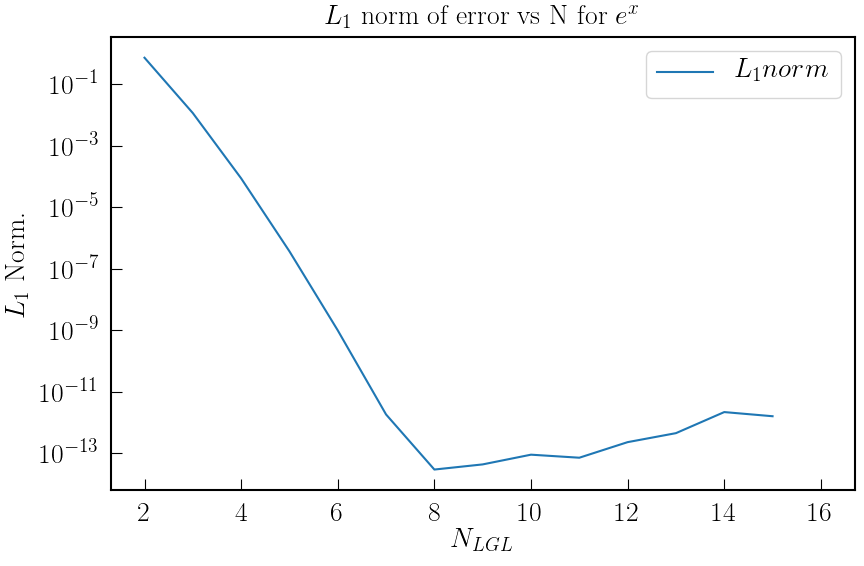

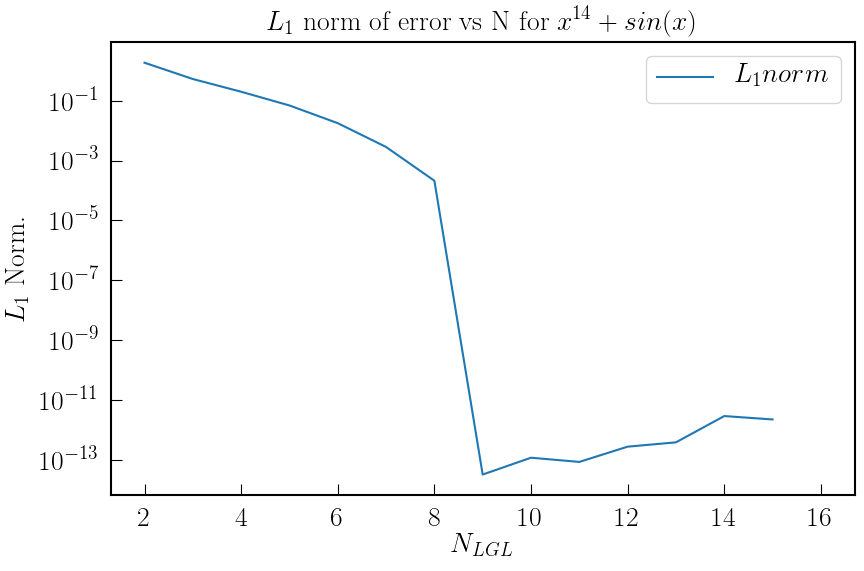

In [70]:
test_Integrate()

$\frac{dx}{d\xi}$ needs to be used throughout the code. A function to calculate the same for an element is in the cell below.

In [15]:
def dx_dxi(x_nodes, xi):
    '''
    Differential :math: `\\frac{dx}{d \\xi}` calculated by central differential
    method about xi using the mapping_xi_to_x function.
    
    Parameters
    ----------
    
    x_nodes : arrayfire.Array
              Contains the nodes of elements
    
    xi      : float
              Value of :math: `\\xi`
    
    Returns
    -------
    dx_dxi : arrayfire.Array
             :math:`\\frac{dx}{d \\xi}`. 
    '''
    dxi = 1e-7
    x2 = mapping_xi_to_x(x_nodes, xi + dxi)
    x1 = mapping_xi_to_x(x_nodes, xi - dxi)
    
    dx_dxi = (x2 - x1) / (2 * dxi)
    
    return dx_dxi

def test_dx_dxi():
    '''
    A Test function to check the dx_xi function in wave_equation module by
    passing nodes of an element and using the LGL points. Analytically, the
    differential would be a constant. The check has a tolerance 1e-9.
    '''
    threshold = 1e-9
    
    nodes      = np.array([7, 10], dtype = np.float64)
    test_nodes = af.interop.np_to_af_array(nodes)
    
    analytical_dx_dxi = 1.5        #calculating (10 - 7) / 2

    check_dx_dxi = abs(af.mean(dx_dxi
                   (test_nodes, xi_LGL)) - analytical_dx_dxi) <= threshold

    assert check_dx_dxi

The strong form (differential form) of the wave equation is converted
to the weak form (integral form). To do this, A test function
$v(x)$ is multiplied with the wave equation and the resultant
expresion is integrated w.r.t. $x$.


\begin{align}
v(x)\frac{\partial u(x, t)}{\partial t}
&+ v(x)\frac{\partial F(u)}{\partial x}
= 0\\
\int v(x)\frac{\partial u(x, t)}{\partial t} dx
&+ \int v(x)\frac{\partial F(u)}{\partial x} dx
= 0 \\
\int v(x)\frac{\partial u(x, t)}{\partial t} dx
&+ v(x) F(u) - \int F(u)\frac{\partial v(x)}{\partial x} dx
= 0 
\end{align}

Taking $u^{n}(x)$ to be the wave function at the $n^{th}$
time step. The aim is to find $u^{n + 1}(x)$ (i.e. wave function at $(n + 1)^{th}$ time step).

Taking an increment of $\Delta t$ in time between the consecutive timesteps $n$ and $n + 1$

\begin{align}
    \frac{\int v(x)u^{n + 1}(x) dx - \int v(x)u^{n}(x) dx}
    {\Delta t} + v(x) F(u^n) - \int F(u^n)\frac{\partial v(x)}{\partial x} dx
    = 0
\end{align}

\begin{align}
    \int v(x)u^{n + 1}(x) dx &- \int v(x)u^{n}(x) dx + \Delta t \{v(x) F(u^n) - \int F(u^n)
    \frac{\partial v(x)}{\partial x} dx\}
    = 0  \\
    \int v(x)u^{n + 1}(x) dx &= \int v(x)u^{n}(x) dx - \Delta t \{v(x) F(u^n) - \int F(u^n)
    \frac{\partial v(x)}{\partial x} dx\}
\end{align}

Mapping $x$ into $\xi$ space (whose domain is [-1, 1]), for a single element,

\begin{align}
    \int^1_{-1} v(\xi)u^{n + 1}(\xi) \frac{dx}{d\xi} d\xi &= \int^1_{-1} v(\xi)u^{n}(\xi)
    \frac{dx}{d\xi}d\xi - \Delta t \{v(\xi) F(u^n) - \int^1_{-1} F(u^n)
    \frac{\partial v(\xi)}{\partial \xi} d\xi\}
\end{align}

Choosing $v(\xi)$ as the Lagrange basis $L_p$
polynomials created using the $N$ Lagrange-Gauss-Lobatto(LGL) points

\begin{align}
    L_p(\xi) =
    \prod_{m = 0, m \neq p}^{m = N - 1} \frac{\xi - \xi_m}{\xi_m - \xi_p}
\end{align}


For each element, the wave function can be written in $\xi$ space
as a linear combination of the Lagrange basis polynomials created
using the LGL points in that space, i.e.,

\begin{align}
    u^n(\xi) = \sum_{i = 0}^{N - 1} u^n_i L_i(\xi)
\end{align}

In the above equation, $u^n_i$ are the coefficients for $L_i$
and $N$ is the total number LGL points inside the $\xi$ space.

Substituting equation $u^n(\xi) = \sum_{i = 0}^{N - 1} u^n_i L_i(\xi)$ and $v(\xi) = L_p(\xi)$
into the modified weak form of the wave equation,

\begin{align}
    \sum_{i = 0}^{N - 1} u^{n + 1}_i \int L_p(\xi)L_i(\xi)
    \frac{dx}{d\xi} d\xi &=
    \sum_{i = 0}^{N - 1} u^n_i \int L_p(\xi)L_i(\xi)
    \frac{dx}{d\xi}d\xi - \Delta t \{L_p(\xi) F(u^n) - \int F(u^n)
    \frac{\partial L_p(\xi)}{\partial \xi} d\xi\}
\end{align}


\begin{align}
A_{pi} &= \int L_p(\xi)L_i(\xi) \frac{dx}{d\xi} d\xi \\
b_p    &= \sum_{i = 0}^{N - 1} u^n_i \int L_p(\xi)L_i(\xi)
\frac{dx}{d\xi}d\xi - \Delta t \{L_p(\xi) F(u^n) - \int F(u^n)
\frac{\partial L_p(\xi)}{\partial \xi} d\xi\}
\end{align}

On varying $p$ from $0$ to $N - 1$, $N$ such linear equations
for $N$ variable $u^{n + 1}_i$, $i \epsilon {0, 1, \cdots, N - 1}$.
Writing all the system of linear equations in matrix representation.

\begin{align}
\begin{bmatrix}
A_{00} & A_{01} & \cdots & A_{0{N-1}} \\
A_{10} & A_{11} & \cdots & A_{1{N-1}} \\
\vdots & \vdots & \ddots & \vdots     \\
A_{(N - 1)0} & A_{(N - 1)1} & \cdots & A_{(N - 1){(N-1)}}
\end{bmatrix}
\begin{bmatrix}
u^{n + 1}_0 \\
u^{n + 1}_1 \\
\vdots      \\
u^{n + 1}_{N - 1}
\end{bmatrix}
=
\begin{bmatrix}
b_0       \\
b_1       \\
\vdots    \\
b_{N - 1} \\
\end{bmatrix}
\end{align}

or

\begin{align}
    Au^{n + 1} = b \\
    u^{n + 1}  = A^{-1} b
\end{align}

As seen above, $u^{n + 1}$ can be obtained if $u^n$ is known. This system of linear equations is for a single element, arranging the wave functions at LGL points mapped for all elements in the form


\begin{align}
    U^n  =  
    \begin{bmatrix}
        u^{n, 0} & u^{n, 1} & u^{n,2} & \cdots & u^{n, N_{Elements} - 1}
    \end{bmatrix}
    =
    \begin{bmatrix}
        u^{n,0}_0 & u^{n,1}_0 & \cdots & u^{n,{N_{Elements} - 1}}_0\\
        u^{n,0}_1 & u^{n,1}_1 & \cdots & u^{n,{N_{Elements} - 1}}_1\\
        u^{n,0}_{N - 1} & u^{n,1}_{N - 1} & \cdots & u^{n,{N_{Elements} - 1}}_{N - 1}\\
    \end{bmatrix}
\end{align}

So the equation which describes the time evolution for all elements can be written as


\begin{align}
    AU^{n + 1} = b \\
    U^{n + 1}  = A^{-1} b
\end{align}

Where $u^{n, i}$ is the wave function at the mapped LGL points at timestep $n$ for an element $i$

## A Matrix
To find the solution of the wave equation in the next time step, the
$A$ matrix has to be calculated, which has elements $A_{pi}$ described as.
\begin{align}
    A_{p i} = \int_{-1}^{1} L_p(\xi)L_i(\xi) \frac{dx}{d\xi} d\xi
\end{align}

This integral can be evaluated using the Gauss-Lobatto Quadrature.

\begin{align}
    \sum_{k = 0}^{N - 1} w_k L_p(\xi_k)L_i(\xi_k) \frac{dx}{d\xi}|_{\xi_k}
\end{align}


Note that all the matrices will be treated as a $3$ dimensional matrix
with the dimensions being represented by $[d1, d2, d3$, where, $d1, d2$
are the dimensions corresponding to the row and column respectively.


\begin{align}
[L_p] &=
\begin{bmatrix}
L_0(\xi_0)       & L_0(\xi_1)       & \cdots & L_0(\xi_{N - 1})       \\
L_1(\xi_0)       & L_1(\xi_1)       & \cdots & L_1(\xi_{N - 1})       \\
\vdots           & \vdots           & \ddots & \vdots                 \\
L_{N - 1}(\xi_0) & L_{N - 1}(\xi_1) & \cdots & L_{N - 1}(\xi_{N - 1})
\end{bmatrix}_{[N, 1, N]}\\
[L_i] &=
\begin{bmatrix}
L_0(\xi_0)       & L_0(\xi_1)       & \cdots & L_0(\xi_{N - 1})       \\
L_1(\xi_0)       & L_1(\xi_1)       & \cdots & L_1(\xi_{N - 1})       \\
\vdots           & \vdots           & \ddots & \vdots                 \\
L_{N - 1}(\xi_0) & L_{N - 1}(\xi_1) & \cdots & L_{N - 1}(\xi_{N - 1})
\end{bmatrix}_{[1, N, N]}\\
[w_k] &=
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots     \\
w_{N - 1}
\end{bmatrix}_{[1, 1, N]} \\
\Bigg[\Bigg (\frac{dx}{d\xi} \Bigg )_k \Bigg ]
&=
\begin{bmatrix}
\frac{dx}{d\xi}|_{\xi = \xi_0} \\
\frac{dx}{d\xi}|_{\xi = \xi_1} \\
\vdots     \\
\frac{dx}{d\xi}|_{\xi = \xi_{N - 1}}
\end{bmatrix}_{[1, 1, N]}
=
\begin{bmatrix}
\Big (\frac{dx}{d\xi} \Big ) \\
\Big (\frac{dx}{d\xi} \Big ) \\
\vdots     \\
\Big (\frac{dx}{d\xi} \Big )
\end{bmatrix}_{[1, 1, N]}
\end{align}

Tiling $[L_p]_{[N, 1, N]}$ across $2^{nd}$ dimension
and $[L_i]_{[1, N, N]}$ along $1^{st}$ dimension multiply corresponding elements

<img src = "notebook_images/Lp_Li_xi_k.png">


To obtain the $A$ matrix, The Integrate() function is used on the above array, which gives.

\begin{align}
A =
\begin{bmatrix}
\sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_0(\xi_k)L_0(\xi_k) & \sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_0(\xi_k)L_1(\xi_k) & \cdots & \sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_0(\xi_k)L_{N - 1}(\xi_k) \\
\sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_1(\xi_k)L_0(\xi_k) & \sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_1(\xi_k)L_1(\xi_k) & \cdots & \sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_1(\xi_k)L_{N - 1}(\xi_k) \\
\vdots & \vdots & \ddots & \vdots \\
\sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_{N - 1}(\xi_k)L_0(\xi_k) & \sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_{N - 1}(\xi_k)L_1(\xi_k) & \cdots & \sum_{k = 0}^{N - 1} w_k \Big(\frac{dx}{d\xi}\Big)_k L_{N - 1}(\xi_k)L_{N - 1}(\xi_k) \\
\end{bmatrix}
\end{align}

This can be simplified using the property of Lagrange basis polynomials calculated over LGL points,

\begin{align}
    L_i(\xi_k) = \delta_{i k}
\end{align}

The A matrix now becomes,

\begin{align}
A =
\begin{bmatrix}
 w_0 \Big(\frac{dx}{d\xi}\Big)_{\xi_0} & 0 & \cdots & 0 \\
0  & w_1 \Big(\frac{dx}{d\xi}\Big)_{\xi_1}  & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots &  w_{N - 1} \Big(\frac{dx}{d\xi}\Big)_{\xi_{N - 1}} \\
\end{bmatrix}
\end{align}

It's known that 

In [61]:
def A_matrix():
    '''
    Returns
    -------
    A_matrix : arrayfire.Array
               The value of integral of product of lagrange basis functions
               obtained by LGL points, using Gauss-Lobatto quadrature method
               using :math: `N_LGL` points.

    [NOTE]:

    The A matrix will vary for each element. The one calculated is for the case
    of 1D elements which are of equal size.
    '''
    
    L_i   = lagrange_basis_value(N_LGL)
    L_p   = af.reorder(L_i, 0, 2, 1)
    L_i   = af.reorder(L_i, 2, 0, 1)
    
    dx_by_dxi   = dx_dxi(boundaries[0 : 2, 0], xi_LGL)
    dx_dxi_tile = af.tile(dx_by_dxi, 1, N_LGL, N_LGL)
    Li_Lp_array = af.broadcast(multiply, L_p, L_i)
    L_element   = (Li_Lp_array * dx_dxi_tile)
    
    A_matrix    = Integrate(8, L_element)
    
    
    return A_matrix

def test_A_matrix():
    '''
    The A matrix is  expected to be a diagonal matrix with weights multiplied with
    :math: `\frac{dx}{d\\xi}` as the diagonal elements.
    '''
    threshold = 1e-10
    
    weights         = lobatto_weights
    identity_matrix = af.identity(N_LGL, N_LGL,\
                          dtype = af.Dtype.f64)
    dx_dxi_element  = af.mean(dx_dxi((boundaries[0 : 2, 0]),\
                                             xi_LGL))
    
    analytical_A_matrix = af.broadcast(multiply,\
                          identity_matrix*dx_dxi_element,\
                          weights)
    calculated_A_matrix = A_matrix()
    
    error = af.max(af.abs(analytical_A_matrix - calculated_A_matrix))
    print(error)
    assert error <= threshold

In [62]:
print(A_matrix())
test_A_matrix()

arrayfire.Array()
Type: double

[8 8 1 1]
    0.0036     0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000 
    0.0000     0.0211     0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0341     0.0000    -0.0000    -0.0000     0.0000    -0.0000 
    0.0000     0.0000     0.0000     0.0412    -0.0000    -0.0000    -0.0000    -0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000     0.0412     0.0000    -0.0000     0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0341    -0.0000    -0.0000 
    0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000     0.0211    -0.0000 
    0.0000     0.0000    -0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0036 


2.603715468561302e-10


AssertionError: 

To obtain the b vector, Its elements $b_p$ described below
need to be calculated

\begin{align}
    b_p    &= \Sigma_{i = 0}^{N - 1} U^{n}_i \int^1_{-1}  L_p(\xi)L_i(\xi)
    \frac{dx}{d\xi}d\xi - \Delta t \{L_p(\xi) F(U^n)|^1_{-1} -
    \int^1_{-1}  F(U^n) \frac{\partial L_p(\xi)}{\partial \xi}
    d\xi\}
\end{align}

The final b vector for all elements would be,

\begin{align}
    b =
    \begin{bmatrix}
    b_0^0       & b_0^1       & \cdots & b_0^{N_{Elements} - 1}       \\
    b_1^0       & b_1^1       & \cdots & b_1^{N_{Elements} - 1}       \\
    \vdots      & \vdots      & \ddots & \vdots                       \\
    b_{N - 1}^0 & b_{N - 1}^1 & \cdots & b_{N - 1}^{N_{Elements} - 1} \\
    \end{bmatrix}_{N \times 1}
\end{align}

$b_p$ consists of three different terms, $\Sigma_{i = 0}^{N - 1} u^n_i
\int^1_{-1}  L_p(\xi)L_i(\xi)\frac{dx}{d\xi}d\xi$,
$\Delta t L_p(\xi) F(u^n)|^1_{-1}$ and $\Delta t
\int^1_{-1}  F(u^n) \frac{\partial L_p(\xi)}{\partial \xi}d\xi$.

The first term of $b_p$,  $\Sigma_{i = 0}^{N - 1} U^n_i
\int^1_{-1}  L_p(\xi)L_i(\xi)\frac{dx}{d\xi}d\xi$ with p varying from
$0$ to $N - 1$ is $A U^n$

By varying p and i from $0$ to $N - 1$ in $\int L_p(\xi)L_i(\xi)\frac{dx}
{d\xi}d\xi$, The A matrix is obtained.

$U^n$ (The displacement of the mapped LGL points across the domain) at timestep n is the obtained from the variable
'U' declared earlier.

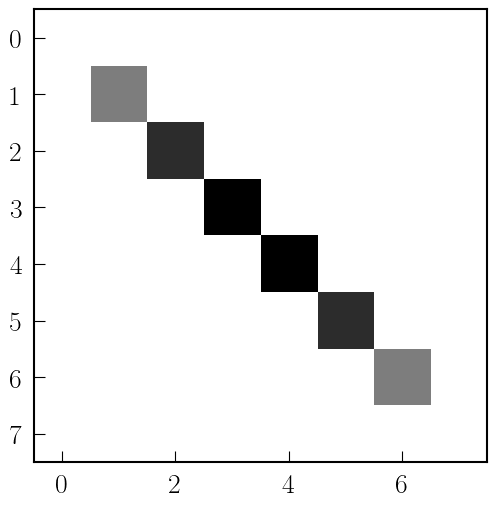

In [18]:
A_matrix_array = np.array(A_matrix())

indices = np.where(A_matrix_array < 0.5*np.max(np.abs(A_matrix_array)))
A_matrix_array[indices] = 0.
plt.imshow(A_matrix_array, cmap='gray_r')

In [19]:
def first_term(t_n, A):
    '''
    '''
    A_u_n = af.matmul(A, U[:, :, t_n])
    
    return A_u_n

In [54]:
#The speed of the wave
c = 1

#The minimum distance between 2 mapped LGL points
delta_x = af.min((element_LGL - 
                  af.shift(element_LGL, 1, 0))[1:, :])
delta_t = delta_x / (20 * c)

#The total time for which the simulation is to be carried out.
total_time  = 10

no_of_steps = int(total_time / delta_t)
end_time    = delta_t * no_of_steps

#Time array consisting of timesteps
time = linspace(0, end_time, no_of_steps)

#c_lax, used in calculation of Lax-Friedrichs flux is taken to be the wave speed.
c_lax = c


# Storing the amplitude of the wave at the mapped LGL points as time evolves
# in a 3D array where timesteps vary along dimension 3.

U = af.constant(0, N_LGL, N_Elements, time.shape[0], dtype = af.Dtype.f64)  


#Initial wave amplitude
U_init      = np.e ** (-(element_LGL)**2 / 0.4**2)
U[:, :, 0]  = U_init

## Lax-Friedrichs flux

By varying p from $0$ to $N - 1$ in the second term (i.e. $F(U^n) L_p(\xi)|^{1}_{-1}$),
Surface term is obtained.

The surface term is used because of the discontinuities in
element boundaries. Since the value of the flux would be
different for adjacent elements, There are two values for $F(u)$ at the 
element boundaries. To resolve this ambiguity of flux,
Lax-Friedrichs flux is introduced.

The Lax-Friedrichs flux $f_M$ for an element boundary between element
$M$ and $M + 1$ at a timestep $n$ is given by,

\begin{equation}
   f_M = \frac{F(u^{n, M+1}_{0}) + F(u^{n, M}_{N - 1})}{2} - 
   \frac{\Delta x}{2\Delta t} (u^{n, M + 1}_{0} - u^{n, M}_{N - 1})
\end{equation}

In the above equation, $u^{n, M + 1}_{0}$ is the amplitude at
the first (leftmost) LGL point of the element with index $M + 1$,
Similarly $u^{n, M}_{N - 1}$ is the $(N - 1)^{th}$ (rightmost) LGL point
of the element with index M, $\Delta x$ is the size of the element M.
This is the flux for element boundaries, It is a number.

In [21]:
def flux_x(u):
    '''
    A function which returns the value of flux for a given wave function u.
    f(u) = c u ** k

    Parameters
    ----------
    u         : arrayfire.Array
                            A 1-D array which contains the value of wave function.

    Returns
    -------
    c * u : arrayfire.Array
            The value of the flux for given u. k = 1 in this case.
    '''
    flux = c * u
    
    return flux



def lax_friedrichs_flux(t_n):
    '''
    A function which calculates the lax-friedrichs_flux :math:`f_i` using.
    :math:`f_i = \\frac{F(u^{i + 1}_0) + F(u^i_{N_{LGL} - 1})}{2} - \frac
                    {\\Delta x}{2\\Delta t} (u^{i + 1}_0 - u^i_{N_{LGL} - 1})`
    
    i.e.- The formula in the cell above.

    Parameters
    ----------
    t_n  : int
           The timestep at which the lax-friedrichs-flux is to be calculated.
    '''

    u_m_plus1_0 = af.shift(U[0, :, t_n], 0, -1)
    u_m_N_LGL   = U[-1, :, t_n]

    flux_m_plus1_0 = flux_x(u_m_plus1_0)
    flux_m_N_LGL   = flux_x(u_m_N_LGL)

    boundary_flux = (flux_m_plus1_0 + flux_m_N_LGL) / 2 \
                        - c_lax * (u_m_plus1_0 - u_m_N_LGL) / 2

    return boundary_flux

def test_lax_friedrichs_flux():
    '''
    A test function to test the laxFriedrichsFlux function in wave_equation
    module.
    '''
    threshold = 1e-12
    
    f_i = lax_friedrichs_flux(0)
    #The lax friedrichs flux at timestep 0 should just be a list of the 
    #amplitude at element boundaries.
    analytical_lax_friedrichs_flux = U[-1, :, 0]
    
    assert af.max(af.abs(analytical_lax_friedrichs_flux - f_i)) < threshold

The Surface term is obtained by varying $p$ in $F(u^n) L_p(\xi)|^{1}_{-1}$
from $0$ to $N - 1$ for an element with an index $M$

\begin{equation}
        F(u^n) L_p(\xi)|^{1}_{-1} =
        L_p (1) f_M - L_p (-1) f_{M - 1}
\end{equation}

The equation above has $L_p (1)$
and $L_p (-1)$. These are elements of 1D arrays of shape $N \times 1$.
Since the index p varies from $0$ to $N -1$ multiplying them with
the flux at the element boundaries (a number),
A vector of shape $N \times 1$ is obtained for a single element.

This when calculated for $N_{Elements}$ elements, An array of shape $N \times N_{Elements}$ is obtained.


In [22]:
#Variables used in calculation of surface term.
L_p_minus1 = lagrange_basis_value(N_LGL)[:, 0]
L_p_1      = lagrange_basis_value(N_LGL)[:, -1]

In [23]:
def surface_term(t_n):
    '''
    A function which is used to calculate the surface term,
    :math:`L_p (1) f_i - L_p (-1) f_{i - 1}`
    using the laxFriedrichsFlux function and the dLp_xi_LGL function in gvar
    module.

    Parameters
    ----------
    t_n : int
          The timestep at which the surface term is to be calculated.

    Returns
    -------
    surface_term : arrayfire.Array [N_LGL N_Elements 1 1]
                    The surface term represented in the form of an array,
                    :math:`L_p (1) f_i - L_p (-1) f_{i - 1}`, where p varies from
                    zero to :math:`N_{LGL}` and i from zero to
                    :math:`N_{Elements}`. p varies along the rows and i along
                    columns.
    '''
    

    f_m        = lax_friedrichs_flux(t_n)
    f_m_minus1 = af.shift(f_m, 0, 1)

    surface_term = af.blas.matmul(L_p_1, f_m) - af.blas.matmul(L_p_minus1,
                                                                f_m_minus1)

    return surface_term


def test_surface_term():
    '''
    A test function to test the surface_term function using
    analytical Lax-Friedrichs flux.
    '''
    threshold = 1e-13


    analytical_f_i        = (U[-1, :, 0])
    analytical_f_i_minus1 = (af.shift(U[-1, :, 0], 0, 1))

    L_p_1                 = af.constant(0, N_LGL, dtype = af.Dtype.f64)
    L_p_1[N_LGL - 1] = 1 

    L_p_minus1    = af.constant(0, N_LGL, dtype = af.Dtype.f64)
    L_p_minus1[0] = 1

    analytical_surface_term = af.blas.matmul(L_p_1, analytical_f_i)\
        - af.blas.matmul(L_p_minus1, analytical_f_i_minus1)

    numerical_surface_term = (surface_term(0))
    assert af.max(af.abs(analytical_surface_term - numerical_surface_term)) \
        < threshold
    return analytical_surface_term

In [24]:
print(surface_term(0))

arrayfire.Array()
Type: double

[8 10 1 1]
   -0.0019    -0.0183    -0.1054    -0.3679    -0.7788    -1.0000    -0.7788    -0.3679    -0.1054    -0.0183 
    0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
   -0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
   -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000 
    0.0183     0.1054     0.3679     0.7788     1.0000     0.7788     0.3679     0.1054     0.0183     0.0019 




## Volume integral flux

The third term of the b vector is
$\int^1_{-1} F(u^n) \frac{\partial L_p(\xi)}
{\partial \xi} d\xi$.
This integral is to be evaluated using Gauss-Lobatto rules.

\begin{align}
    \int^1_{-1} F(u^n) \frac{\partial L_p(\xi)}
    {\partial \xi} d\xi
    = \Sigma_{k = 0}^{N - 1} w_k
    \frac{\partial L_p(\xi)}{\partial \xi}|_{\xi_k}
    F(u^n)
\end{align}

By varying $p$ from $0$ to $N - 1$ along the rows and $k$ from $0$
to $N - 1$ across the columns, $w_k \frac{\partial L_p(\xi)}
{\partial \xi}|_{\xi_k}$ becomes a 2D array of shape $N \times N$

\begin{align}
w_k \frac{\partial L_p(\xi)}{\partial \xi}|_{\xi_k} =
 \begin{bmatrix}
  w_0\frac{\partial L_0(\xi)}{\partial \xi}|_{\xi_0} &
  w_1\frac{\partial L_0(\xi)}{\partial \xi}|_{\xi_1} &
  \cdots & w_{N - 1}\frac{\partial L_0(\xi)}
  {\partial \xi}|_{\xi_{N - 1}}\\
  w_0\frac{\partial L_1(\xi)}{\partial \xi}|_{\xi_0} &
  w_1\frac{\partial L_1(\xi)}{\partial \xi}|_{\xi_1} &
  \cdots & w_{N - 1}\frac{\partial L_1(\xi)}
  {\partial \xi}|_{\xi_{N - 1}}\\
  \vdots & \vdots & \ddots & \vdots        \\
  w_0\frac{\partial L_{N - 1}(\xi)}{\partial \xi}|_{\xi_0} &
  w_1\frac{\partial L_{N - 1}(\xi)}{\partial \xi}|_{\xi_1} &
  \cdots & w_{N - 1}\frac{\partial L_{N - 1}(\xi)}
  {\partial \xi}|_{\xi_{N -1}}\\
 \end{bmatrix}_{N \times N}
\end{align}

While $F(u^n)$ is

\begin{align}
    F(u^n) = c u^n = c
    \begin{bmatrix}
    u^{n}_0 \\
    u^{n}_1 \\
    \vdots      \\
    u^{n}_{N - 1}
    \end{bmatrix}_{N \times 1}
\end{align}

Matrix multiplication of the above two matrices
gives a vector of shape $N \times 1$


An algorithm to calculate the volume integral flux is required.
As observed earlier, $w_k \frac{\partial L_p(\xi)}
{\partial \xi}|_{\xi_k}$ , are the elements of a 2D matrix with k
varying across the columns and p along the rows.

#### Calculating $\frac{\partial L_p(\xi)}{\partial \xi}|_{\xi_k}$


To calculate $\frac{\partial L_p(\xi)}{\partial \xi}|_{\xi_k}$,
If we assume the lagrange basis polynomials to be of the form

\begin{align}
    L_p(\xi) = a^{N - 1}_p \xi^{N - 1} + a^{N - 2}_p \xi^{N - 2} + . . . + a^1_p \xi^1 + a^0_p \xi^0
\end{align}

An array containing the coefficients of the Lagrange basis
polynomials is obtained.

\begin{align}
 \begin{pmatrix}
  a^{N - 1}_0 & a^{N - 2}_0 & \cdots & a^0_0\\
  a^{N - 1}_1 & a^{N - 2}_1 & \cdots & a^0_1\\
  \vdots & \vdots &\ddots & \vdots\\
  a^{N - 1}_p & a^{N - 2}_p & \cdots & a^0_p\\
  \vdots & \vdots &\ddots & \vdots\\
  a^{N - 1}_{N - 1} & a^{N - 2}_{N - 1} & \cdots & a^0_{N - 1}
 \end{pmatrix}_{N \times N}
\end{align}

$L_p'$ becomes
$L_p'(\xi) = (N - 1) a^{N - 1}_p \xi^{N - 2}
+ (N - 2) a^{N - 2}_p \xi^{N - 3} + ... + a^1_p \xi^0 $

While taking the differential, all $a^0_p$ coefficients disappear,
Another matrix containing the coefficients of $\frac{\partial
L_p(\xi)}{\partial \xi}$ is created.

\begin{align}
 \begin{pmatrix}
  (N - 1) a^{N - 1}_0 & (N - 2) a^{N - 2}_0 & \cdots & a^1_0\\
  (N - 1) a^{N - 1}_1 & (N - 2) a^{N - 2}_1 & \cdots & a^1_1\\
  \vdots & \vdots &\ddots & \vdots\\
  (N - 1) a^{N - 1}_p & (N - 2) a^{N - 2}_p & \cdots & a^1_p\\
  \vdots & \vdots &\ddots & \vdots\\
  (N - 1) a^{N - 1}_{N - 1} & (N - 2) a^{N - 2}_{N - 1} & \cdots
  & a^1_{N - 1}
 \end{pmatrix}_{N \times (N - 1)}
\end{align}

Splicing matrix containing the coefficients of the Lagrange basis polynomials
by removing the last column provides the $a^n_p$ coefficients required for matrix above.
Broadcasting and multiplying a matrix $[(N - 1), (N - 2), . . ., 1]$ to
this spliced matrix gives the matrix


Another matrix containing the powers of $\xi$

\begin{align}
 \begin{pmatrix}
  \xi^{N - 2}_0 & \xi^{N - 2}_1 & \cdots & \xi^{N - 2}_{N - 1} \\
  \xi^{N - 3}_0 & \xi^{N - 3}_1 & \cdots & \xi^{N - 3}_{N - 1} \\
  \vdots        & \vdots        & \ddots & \vdots              \\
  \xi^{i}_0     & \xi^{i}_1     & \cdots & \xi^{i}_{N - 1}     \\
  \vdots        & \vdots        & \ddots & \vdots              \\
  \xi^{1}_0     & \xi^{1}_1     & \cdots & \xi^{1}_{N - 1}
 \end{pmatrix}_{(N - 1) \times N}
\end{align}



Matrix multiplication results in

\begin{align}
 \begin{bmatrix}
  \frac{\partial L_0(\xi)}{\partial \xi}|_{\xi_0} &
  \frac{\partial L_0(\xi)}{\partial \xi}|_{\xi_1} &
  \cdots & \frac{\partial L_0(\xi)}
  {\partial \xi}|_{\xi_{N - 1}}\\
  \frac{\partial L_1(\xi)}{\partial \xi}|_{\xi_0} &
  \frac{\partial L_1(\xi)}{\partial \xi}|_{\xi_1} &
  \cdots & \frac{\partial L_1(\xi)}
  {\partial \xi}|_{\xi_{N - 1}}\\
  \vdots & \vdots & \ddots & \vdots        \\
  \frac{\partial L_{N - 1}(\xi)}{\partial \xi}|_{\xi_0} &
  \frac{\partial L_{N - 1}(\xi)}{\partial \xi}|_{\xi_1} &
  \cdots & \frac{\partial L_{N - 1}(\xi)}
  {\partial \xi}|_{\xi_{N -1}}\\
 \end{bmatrix}_{N \times N}
\end{align}


In the cell below, $\frac{d L_p}{d \xi}$ is calculated and compared with the values obtained
using SAGE $\href{https://cocalc.com/projects/1b7f404c-87ba-40d0-816c-2eba17466aa8/files
    /PM_2_5/wave_equation/worksheets/dLp_xi.sagews}{\mathrm {worksheet}}$

In [25]:
def dLp_xi_LGL():
    '''
    Calculates \\frac{d L_p(\\xi)}{d \\xi} at \\xi_k
    
    This is arranged in a 2D array
    
    Returns
    -------
    dLp_xi        : arrayfire.Array [N N 1 1]
                    A 2D array :math: `L_i (\\xi_p)`, where i varies
                    along dimension 1 and p varies along second dimension.
    Examples
    --------
    The fifth column has elements \\frac{d L_p (\\xi)}{d \\xi}
    at the fifth LGL point with p varying from 0 to N - 1
    
    The fifth row of the array has elements \\frac{d L_4 (\\xi)}{d \\xi}
    i.e.- The differential of Lagrange basis polynomial with index 4
    calculated over all the LGL points
    '''
    differentiation_coeffs = (af.transpose(af.flip(af.tile\
                              (af.range(N_LGL), 1, N_LGL)))\
                              * l_basis_coeffs)[:, :-1]

    xi_array   = af.transpose(LGL_points(N_LGL))
    index      = af.flip(af.range(N_LGL - 1))
    xi_power   = af.broadcast(power, xi_array, index)
    dLp_xi     = af.blas.matmul(differentiation_coeffs, xi_power)

    return dLp_xi

def test_dLp_xi_LGL():
    '''
    Test function to check the dLp_xi calculated in gvar mdule with a
    numerically obtained one.

    Refrence
    --------
    The link to the sage worksheet where the calculations were carried out.
    https://cocalc.com/projects/1b7f404c-87ba-40d0-816c-2eba17466aa8/files
    /PM_2_5/wave_equation/worksheets/dLp_xi.sagews
    '''
    threshold = 1e-10
    
    reference_d_Lp_xi = af.interop.np_to_af_array(np.array([\
    [-14.0000000000226,-3.20991570302344,0.792476681323880,-0.372150435728984,\
    0.243330712724289,-0.203284568901545,0.219957514771985, -0.500000000000000],

    [18.9375986071129, 3.31499272476776e-11, -2.80647579473469,1.07894468878725\
    ,-0.661157350899271,0.537039586158262, -0.573565414940005,1.29768738831567],

    [-7.56928981931106, 4.54358506455201, -6.49524878326702e-12, \
    -2.37818723350641, 1.13535801687865, -0.845022556506714, 0.869448098330221,\
    -1.94165942553537],

    [4.29790816425547,-2.11206121431525,2.87551740597844,-1.18896004153157e-11,\
    -2.38892435916370, 1.37278583181113, -1.29423205091574, 2.81018898925442],

    [-2.81018898925442, 1.29423205091574, -1.37278583181113, 2.38892435916370, \
    1.18892673484083e-11,-2.87551740597844, 2.11206121431525,-4.29790816425547],

    [1.94165942553537, -0.869448098330221, 0.845022556506714,-1.13535801687865,\
    2.37818723350641, 6.49524878326702e-12,-4.54358506455201,7.56928981931106],\

    [-1.29768738831567, 0.573565414940005,-0.537039586158262,0.661157350899271,\
    -1.07894468878725,2.80647579473469,-3.31498162253752e-11,-18.9375986071129],

    [0.500000000000000,-0.219957514771985,0.203284568901545,-0.243330712724289,\
    0.372150435728984, -0.792476681323880, 3.20991570302344, 14.0000000000226]
    ]))
    
    
    assert af.max(reference_d_Lp_xi - dLp_xi_LGL()) < threshold

In [26]:
print(dLp_xi_LGL())

arrayfire.Array()
Type: double

[8 8 1 1]
  -14.0000    -3.2099     0.7925    -0.3722     0.2433    -0.2033     0.2200    -0.5000 
   18.9376     0.0000    -2.8065     1.0789    -0.6612     0.5370    -0.5736     1.2977 
   -7.5693     4.5436    -0.0000    -2.3782     1.1354    -0.8450     0.8694    -1.9417 
    4.2979    -2.1121     2.8755     0.0000    -2.3889     1.3728    -1.2942     2.8102 
   -2.8102     1.2942    -1.3728     2.3889     0.0000    -2.8755     2.1121    -4.2979 
    1.9417    -0.8694     0.8450    -1.1354     2.3782    -0.0000    -4.5436     7.5693 
   -1.2977     0.5736    -0.5370     0.6612    -1.0789     2.8065    -0.0000   -18.9376 
    0.5000    -0.2200     0.2033    -0.2433     0.3722    -0.7925     3.2099    14.0000 




In [27]:
#Variable used in calculation of volume integral flux.
diff_Lp_array = dLp_xi_LGL()

In [48]:
def volume_flux_integrand_at_LGL_points(U):
    '''
    Calculates the value of the integrand in volume integral flux
    
    :math: `F(u^n) \\frac{\\partial L_p(\\xi)}
    {\\partial \\xi}`
    
    at the LGL points.
    
    Parameters
    ----------
    U : arrayfire.Array [N_LGL N_Elements 1 1]
        A 1-D array containing the value of the wave function at the
        mapped LGL nodes in the element.

    Returns
    -------
    flux_integrand_at_LGL_points : arrayfire.Array [N_LGL N_Elements 1 1]
                                   2D matrix containing the value of the
                                   integrand
    '''
    dLp_xi = af.reorder(diff_Lp_array, 0, 2, 1)
    flux   = af.reorder(flux_x(U), 2, 1, 0)
    flux_integrand_at_LGL_points = af.broadcast(multiply, flux, dLp_xi)
    
    return flux_integrand_at_LGL_points

def volume_integral_flux(U):
    '''
    Calculates the value of the integral
    
    :math: `$\\int^1_{-1} F(u^n) \frac{\\partial L_p(\\xi)}
    {\\partial \\xi} d\\xi$` 
    
    using the Integrate() function and the global variable
    lobatto_weights.
    
    Parameters
    ----------
    U : arrayfire.Array [N_LGL N_Elements 1 1]
        A 1-D array containing the value of the wave function at the
        mapped LGL nodes in the element.

    Returns
    -------
    flux_integral : arrayfire.Array [1 N 1 1]
                    A 1-D array of the value of the flux integral calculated
                    for various lagrange basis functions.
    '''
    flux_integral = Integrate(N_LGL, volume_flux_integrand_at_LGL_points(U)) 
    
    return flux_integral

def test_volume_integral_flux():
    '''
    A test function to check the volume_integral_flux function in wave_equation
    module by analytically calculated Gauss-Lobatto quadrature.

    Reference
    ---------
    The link to the sage worksheet where the calculations were caried out is
    given below.
    https://cocalc.com/projects/1b7f404c-87ba-40d0-816c-2eba17466aa8/files
    /PM_2_5/wave_equation/worksheets/volume_integral_flux.sagews

    '''
    threshold = 4 * 1e-8
    
    referenceFluxIntegral = af.transpose(af.np_to_af_array(np.array([
        [-0.002016634876668093, -0.000588597708116113, -0.0013016773719126333,\
        -0.002368387579324652, -0.003620502047659841, -0.004320197094090966,
        -0.003445512010153811, 0.0176615086879261],\
        [-0.018969769374, -0.00431252844519,-0.00882630935977,-0.0144355176966,\
        -0.019612124119, -0.0209837936827, -0.0154359890788, 0.102576031756], \
        [-0.108222418798, -0.0179274222595, -0.0337807018822, -0.0492589052599,\
        -0.0588472807471, -0.0557970236273, -0.0374764132459, 0.361310165819],\
        [-0.374448714304, -0.0399576371245, -0.0683852285846, -0.0869229749357,\
        -0.0884322503841, -0.0714664112839, -0.0422339853622, 0.771847201979], \
        [-0.785754362849, -0.0396035640187, -0.0579313769517, -0.0569022801117,\
        -0.0392041960688, -0.0172295769141, -0.00337464521455, 1.00000000213],\
        [-1.00000000213, 0.00337464521455, 0.0172295769141, 0.0392041960688,\
        0.0569022801117, 0.0579313769517, 0.0396035640187, 0.785754362849],\
        [-0.771847201979, 0.0422339853622, 0.0714664112839, 0.0884322503841, \
        0.0869229749357, 0.0683852285846, 0.0399576371245, 0.374448714304],\
        [-0.361310165819, 0.0374764132459, 0.0557970236273, 0.0588472807471,\
        0.0492589052599, 0.0337807018822, 0.0179274222595, 0.108222418798], \
        [-0.102576031756, 0.0154359890788, 0.0209837936827, 0.019612124119, \
        0.0144355176966, 0.00882630935977, 0.00431252844519, 0.018969769374],\
        [-0.0176615086879, 0.00344551201015 ,0.00432019709409, 0.00362050204766,\
        0.00236838757932, 0.00130167737191, 0.000588597708116, 0.00201663487667]])))

    numerical_flux = volume_integral_flux(U[:, :, 0])
    
    return (af.max(af.abs(numerical_flux - referenceFluxIntegral)) < threshold)

In [49]:
print(volume_integral_flux(U[:, :, 0]))

arrayfire.Array()
Type: double

[8 10 1 1]
   -0.0020    -0.0190    -0.1082    -0.3744    -0.7858    -1.0000    -0.7718    -0.3613    -0.1026    -0.0177 
   -0.0006    -0.0043    -0.0179    -0.0400    -0.0396     0.0034     0.0422     0.0375     0.0154     0.0034 
   -0.0013    -0.0088    -0.0338    -0.0684    -0.0579     0.0172     0.0715     0.0558     0.0210     0.0043 
   -0.0024    -0.0144    -0.0493    -0.0869    -0.0569     0.0392     0.0884     0.0588     0.0196     0.0036 
   -0.0036    -0.0196    -0.0588    -0.0884    -0.0392     0.0569     0.0869     0.0493     0.0144     0.0024 
   -0.0043    -0.0210    -0.0558    -0.0715    -0.0172     0.0579     0.0684     0.0338     0.0088     0.0013 
   -0.0034    -0.0154    -0.0375    -0.0422    -0.0034     0.0396     0.0400     0.0179     0.0043     0.0006 
    0.0177     0.1026     0.3613     0.7718     1.0000     0.7858     0.3744     0.1082     0.0190     0.0020 




In [50]:
def b_vector(t_n):
    '''
    For doing the time evolution of the wave equation we have reduced the
    problem to solving a system of linear equations given by
    :math:`Au = b`
    where :math:`A` is the A matrix, :math:`b` is the b vector and :math:`u`
    is the wave function to be found at the next time step.
    
    :math:`b` is given by the equation
    
    :math::
        `
        b =  \\Delta t {\\int \\frac{dL_p}{d\\xi} F(u) d\\xi
            - L_p(\\xi) F(u)}
        `
    
    here :math:`L_p * F` is called the surface term and it is got using the
    the function `surfaceTerm`.
    The other terms are got using the function `volume_integral`.
    
    Then, b = dt * (volume_integral - surfaceTerm)
    
    Parameters
    ----------
    t_n : double

    Returns
    -------
    b_vector_array : arrayfire.Array
    '''
    
    volume_integral = volume_integral_flux(U[:, :, t_n])
    Surface_term    = surface_term(t_n)
    b_vector_array  = first_term(t_n, A)\
                      + delta_t * (volume_integral - Surface_term)
    

    return b_vector_array


Now the wave equation can be evolved using

\begin{align}
    AU^{n + 1} = b \\
    U^{n + 1}  = A^{-1} b
\end{align}

The initial amplitude, $U^0$ is set using 'u_init'

In [55]:
def time_evolution():
    '''
    Function which solves the wave equation
    :math: `u^{t_n + 1} = b(t_n) \\times A`
    iterated over time steps t_n and then plots :math: `x` against the amplitude
    of the wave. The images are then stored in Wave folder.
    '''
    
    A_inverse   = af.inverse(A_matrix())
    
    for t_n in trange(0, time.shape[0] - 1):
        U[:, :, t_n + 1] = af.matmul(A_inverse, b_vector(t_n))

    print('u calculated!')

    subprocess.run(['mkdir', 'results/1D_Wave_images'])

    for t_n in trange(0, time.shape[0] - 1):
        if t_n % 100 == 0:
            fig  = plt.figure()
            axes = plt.gca()
            x    = element_LGL
            y    = U[:, :, t_n]
            
            plt.plot(x, y)
            axes.set_ylim(-1, 2)
            plt.xlabel('x')
            plt.ylabel('Amplitude')
            plt.title('Time = %f' % (t_n * delta_t))
            fig.savefig('results/1D_Wave_images/%04d' %(t_n / 100) + '.png')
            plt.close('all')
    
    # Creating a movie with the images created.
    os.system("cd results/1D_Wave_images && ffmpeg -f image2 -i %04d.png -vcodec mpeg4\
              -mbd rd -trellis 2 -cmp 2 -g 300 -pass 1 -r 25 -b 18000000 movie.mp4\
              && rm -f ffmpeg2pass-0.log && mv movie.mp4 /home/f2013305/DG_Maxwell/code")

    return

In [56]:
#A matrix which is used for time stepping
A = A_matrix()


In [57]:
time_evolution()

  0%|          | 0/15592 [00:00<?, ?it/s]

u calculated!


100%|██████████| 15592/15592 [00:37<00:00, 414.39it/s]


In [ ]:
def test_functions():
    '''
    A function which runs all test functions.
    Parameters for the test functions
    N_LGL      = 8
    N_Elements = 10
    c          = 1
    '''
    test_A_matrix()
    test_dLp_xi_LGL()
    test_dx_dxi()
    test_lagrange_basis_coeffs()
    test_lagrange_basis_value()
    test_lax_friedrichs_flux()
    test_LGL_points()
    test_mapping_xi_to_x()
    test_surface_term()
    test_volume_integral_flux()
    
    return

In [ ]:
test_functions()